## 1.数据分析+数据预处理

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import xgboost as xgb
import os

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import joblib
from sklearn.ensemble import VotingRegressor

采用000016深康佳公司的数据进行预测，此处的股票数据已更新过，包含了2024年9月的股票数据

In [3]:
# 忽略warnings
import warnings
warnings.filterwarnings('ignore')

# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

path = 'data/'
data = pd.read_csv(path + '000016深康佳Ａ.csv')

In [4]:
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   日期       501 non-null    object 
 1   开盘       501 non-null    float64
 2   收盘       501 non-null    float64
 3   涨跌额      501 non-null    float64
 4   涨跌幅      501 non-null    object 
 5   最低       501 non-null    float64
 6   最高       501 non-null    float64
 7   成交量(手)   501 non-null    int64  
 8   成交金额(万)  501 non-null    float64
 9   换手率      501 non-null    object 
dtypes: float64(6), int64(1), object(3)
memory usage: 39.3+ KB


(           日期    开盘    收盘   涨跌额     涨跌幅    最低    最高   成交量(手)   成交金额(万)    换手率
 0  2024-09-30  3.11  3.31  0.28   9.24%  3.03  3.32  1220325  39156.35  7.64%
 1  2024-09-27  2.94  3.03  0.11   3.77%  2.92  3.10   997023  29919.40  6.24%
 2  2024-09-26  2.85  2.92  0.05   1.74%  2.82  2.93   795939  23090.30  4.99%
 3  2024-09-25  2.90  2.87 -0.03  -1.03%  2.83  2.97  1026790  29782.44  6.43%
 4  2024-09-24  2.97  2.90  0.02   0.69%  2.79  2.97  1318475  37882.04  8.26%,
 None)

In [5]:
data.shape

(501, 10)

In [6]:
data.describe()

,开盘,收盘,涨跌额,最低,最高,成交量(手),成交金额(万)
count,501.000000,501.000000,501.000000,501.000000,501.000000,5.010000e+02,501.000000
mean,4.035050,4.030439,-0.004731,3.974072,4.095409,2.091469e+05,7409.278044
std,0.968421,0.964283,0.087994,0.969116,0.962947,2.549129e+05,7476.854214
min,1.950000,1.930000,-0.350000,1.870000,1.980000,4.782900e+04,2189.170000
25%,3.140000,3.140000,-0.060000,3.100000,3.260000,9.064400e+04,3708.260000
50%,4.340000,4.330000,-0.010000,4.300000,4.380000,1.216080e+05,4996.620000
75%,4.810000,4.810000,0.040000,4.760000,4.870000,2.004600e+05,7175.730000
max,5.750000,5.700000,0.380000,5.640000,5.780000,2.114670e+06,66499.240000


In [7]:
# 查看缺失值
data.isnull().sum()

日期         0
开盘         0
收盘         0
涨跌额        0
涨跌幅        0
最低         0
最高         0
成交量(手)     0
成交金额(万)    0
换手率        0
dtype: int64

<Axes: >

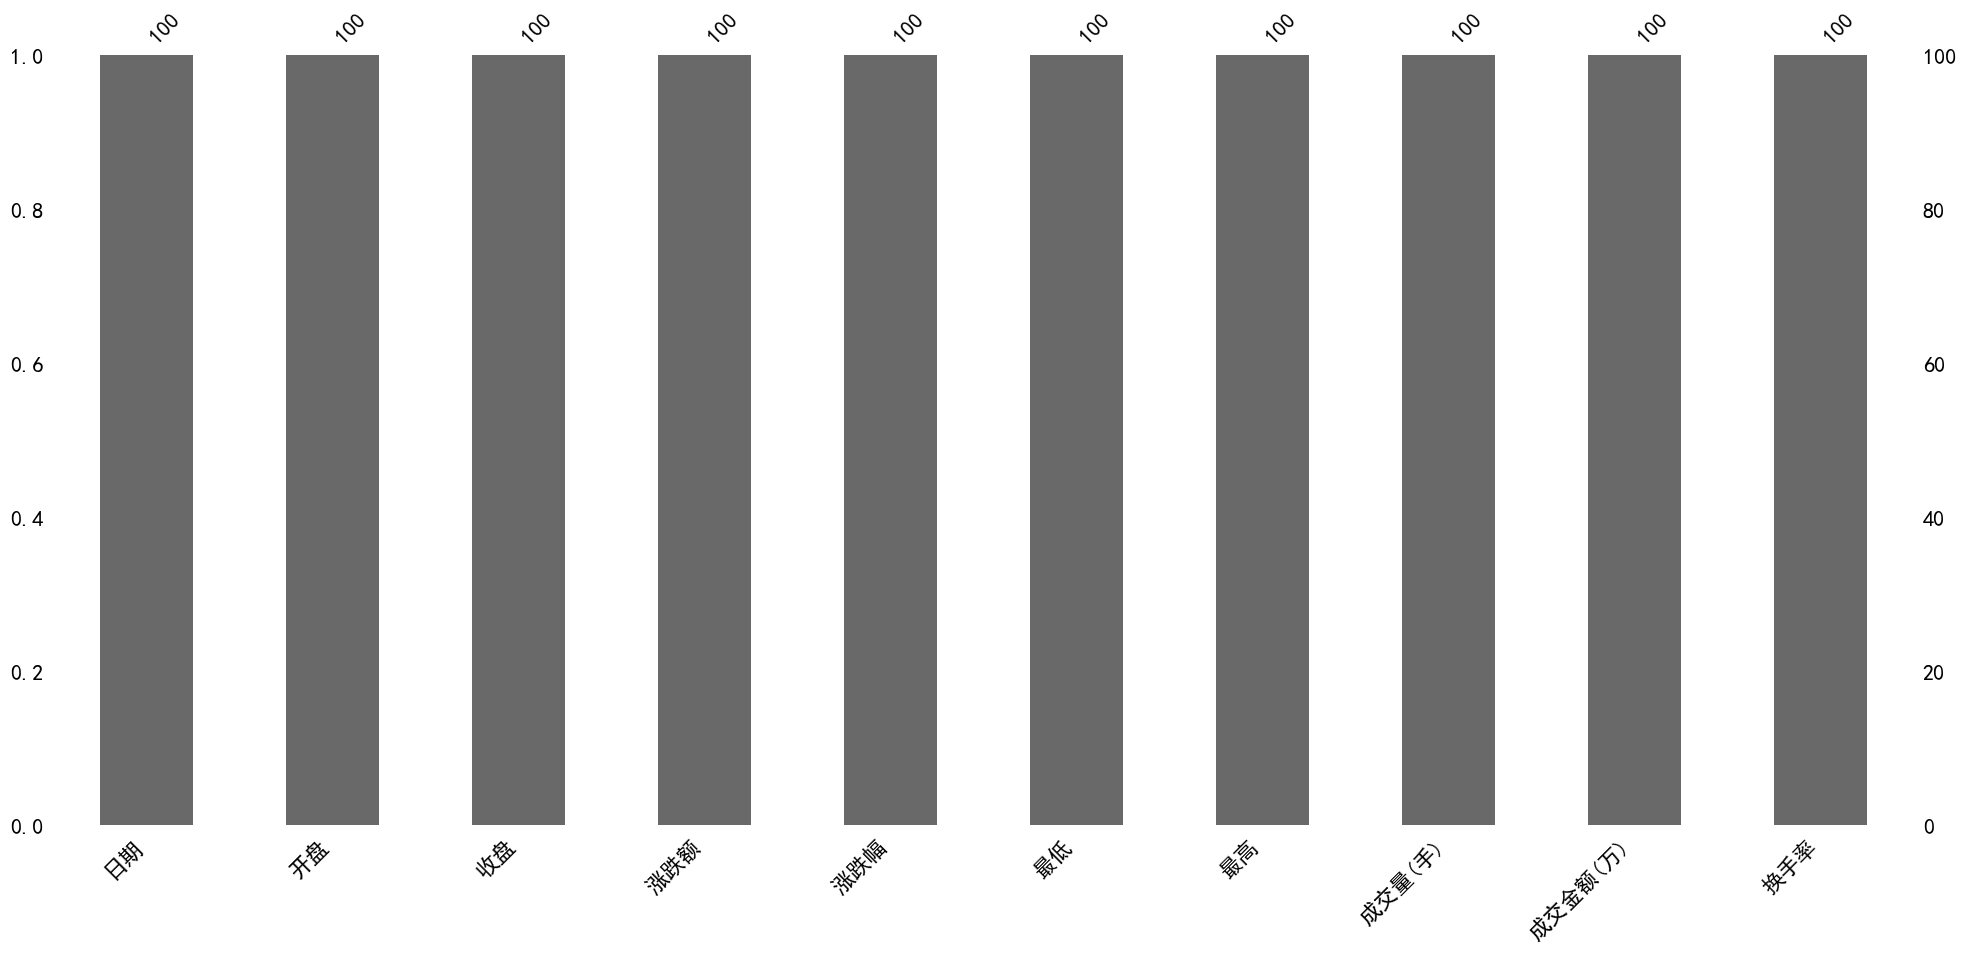

In [8]:
# 都没有缺失值，不需要处理缺失值
msno.bar(data.sample(100))

In [9]:
# 把日期转换为时间格式
data['日期'] = pd.to_datetime(data['日期'])
data['日期'].head()

0   2024-09-30
1   2024-09-27
2   2024-09-26
3   2024-09-25
4   2024-09-24
Name: 日期, dtype: datetime64[ns]

<Axes: title={'center': 'Log Normal'}, xlabel='最高'>

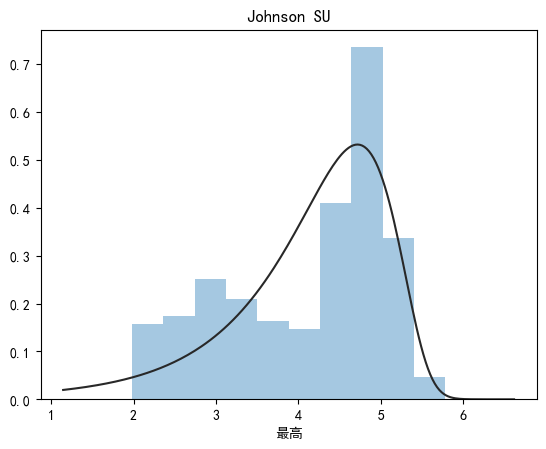

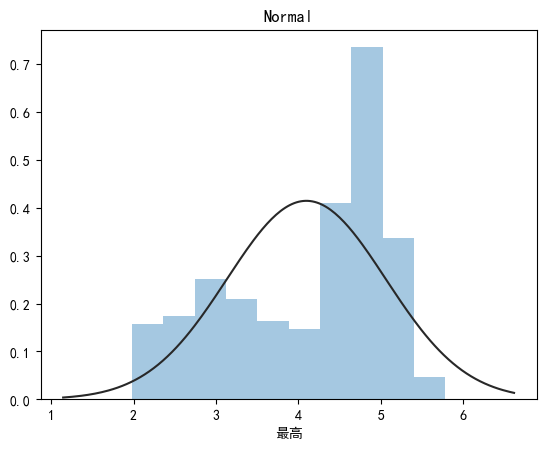

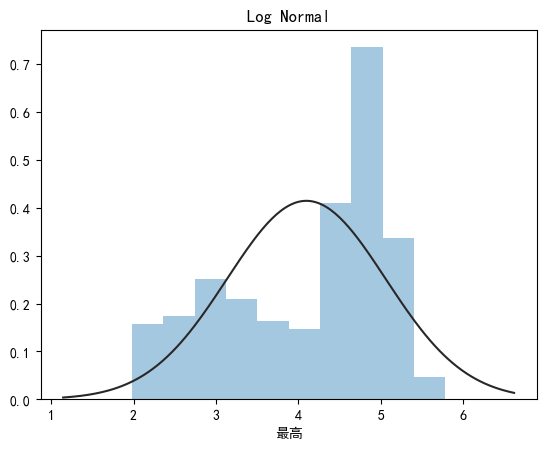

In [10]:
import scipy.stats as st
y = data['最高']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

可以看出，最高价大致满足正态分布，所以之后可以不用对其进行正态化处理

<Axes: title={'center': 'Log Normal'}, xlabel='最低'>

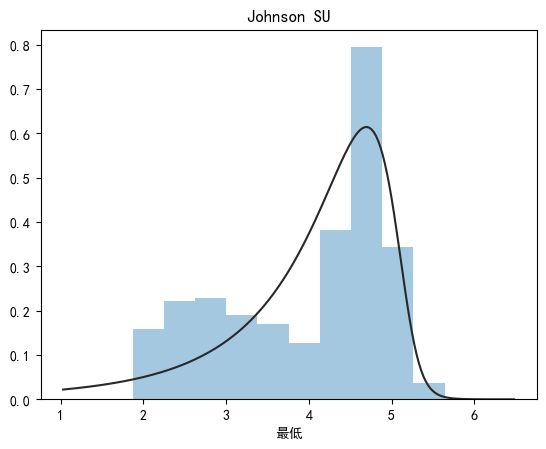

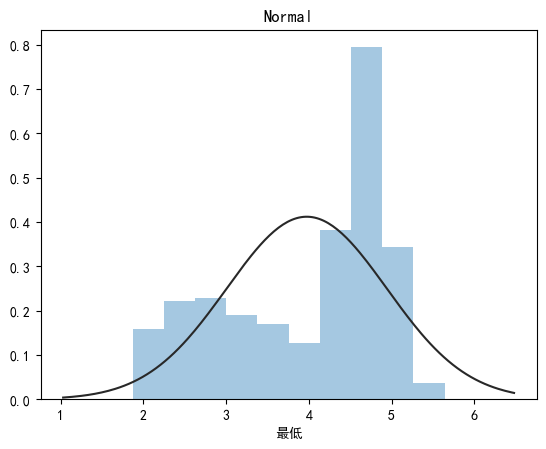

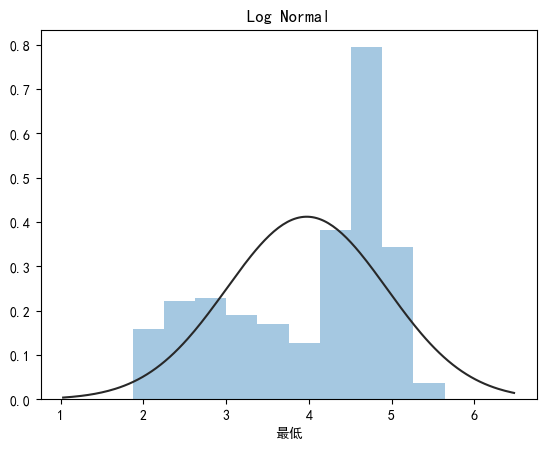

In [11]:
import scipy.stats as st
y = data['最低']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

Skewness: -0.605851
Kurtosis: -0.901837


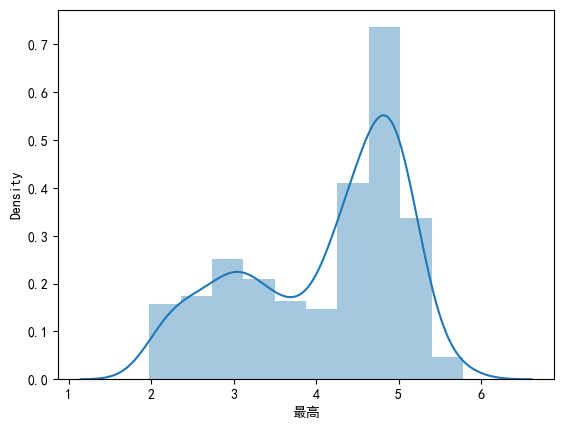

In [12]:
# 查看数据的偏度和峰度
sns.distplot(data['最高'])
print("Skewness: %f" % data['最高'].skew())
print("Kurtosis: %f" % data['最高'].kurt())

偏度值<0,说明数据较为左偏；峰度值的绝对值在3以内，说明数据较为平坦，并且都在可接受范围之内

In [13]:
# 去除"涨跌幅"和"换手率"列中的百分号并转换为浮点数
data['涨跌幅'] = data['涨跌幅'].str.rstrip('%').astype(float)
data['换手率'] = data['换手率'].str.rstrip('%').astype(float)

# 只对数值列计算偏度和峰度
numeric_cols = data.select_dtypes(include=[np.number])
numeric_cols.skew(), numeric_cols.kurt()

(开盘        -0.616654
 收盘        -0.615266
 涨跌额        0.298285
 涨跌幅        0.627539
 最低        -0.619337
 最高        -0.605851
 成交量(手)     3.719064
 成交金额(万)    3.680503
 换手率        3.718670
 dtype: float64,
 开盘         -0.925223
 收盘         -0.939206
 涨跌额         2.243745
 涨跌幅         4.744220
 最低         -0.958284
 最高         -0.901837
 成交量(手)     17.182470
 成交金额(万)    17.739348
 换手率        17.179537
 dtype: float64)

由于特征全部为数字特征，所以只进行数字特征的处理

In [14]:
data.columns

Index(['日期', '开盘', '收盘', '涨跌额', '涨跌幅', '最低', '最高', '成交量(手)', '成交金额(万)', '换手率'], dtype='object')

In [15]:
features = ['最高', '最低', '开盘', '收盘', '涨跌幅', '换手率', '成交量(手)', '成交金额(万)']

In [16]:
# 查看特征之间的相关性
price_numeric = data[features]
correlation = price_numeric.corr()
print(correlation['最高'].sort_values(ascending = False),'\n')

最高         1.000000
收盘         0.998204
开盘         0.997728
最低         0.997460
涨跌幅       -0.015856
成交金额(万)   -0.187590
成交量(手)    -0.396686
换手率       -0.396765
Name: 最高, dtype: float64 



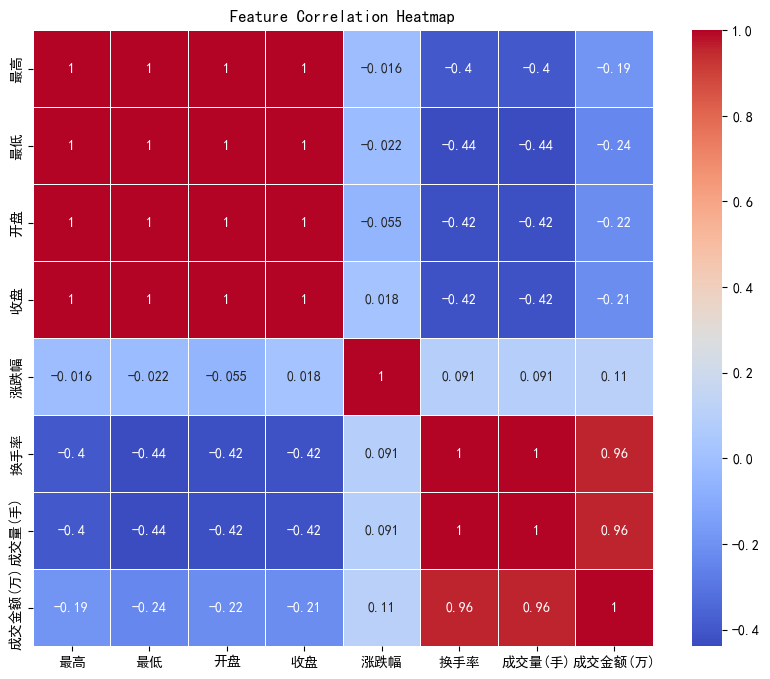

In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

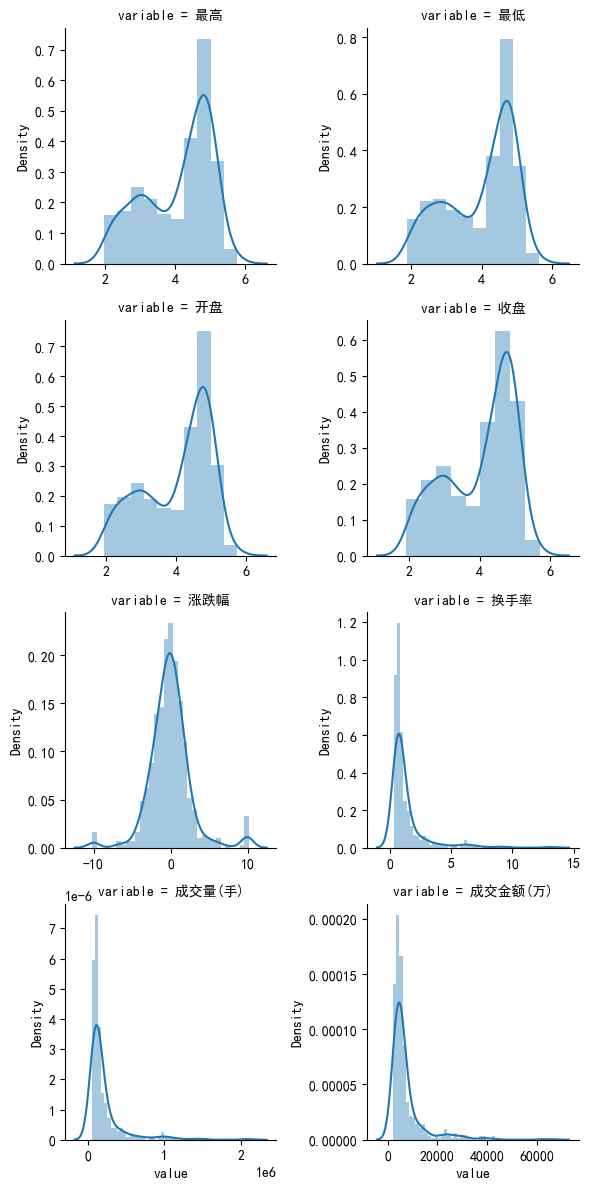

In [18]:
# 每个数字特征的分布可视化
f = pd.melt(data, value_vars = features)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

由于发现收盘、开盘这两个变量与最高相关性过高，很可能会导致数据的过拟合，因此删除该两个变量。而涨跌幅相关性又过低，因此删除

In [19]:
data = data.drop(columns=['收盘', '开盘', '涨跌幅'])
data.head()

,日期,涨跌额,最低,最高,成交量(手),成交金额(万),换手率
0,2024-09-30,0.28,3.03,3.32,1220325,39156.35,7.64
1,2024-09-27,0.11,2.92,3.10,997023,29919.40,6.24
2,2024-09-26,0.05,2.82,2.93,795939,23090.30,4.99
3,2024-09-25,-0.03,2.83,2.97,1026790,29782.44,6.43
4,2024-09-24,0.02,2.79,2.97,1318475,37882.04,8.26


## 2.特征工程

查看数据最高和最低列的箱线图，删除异常值

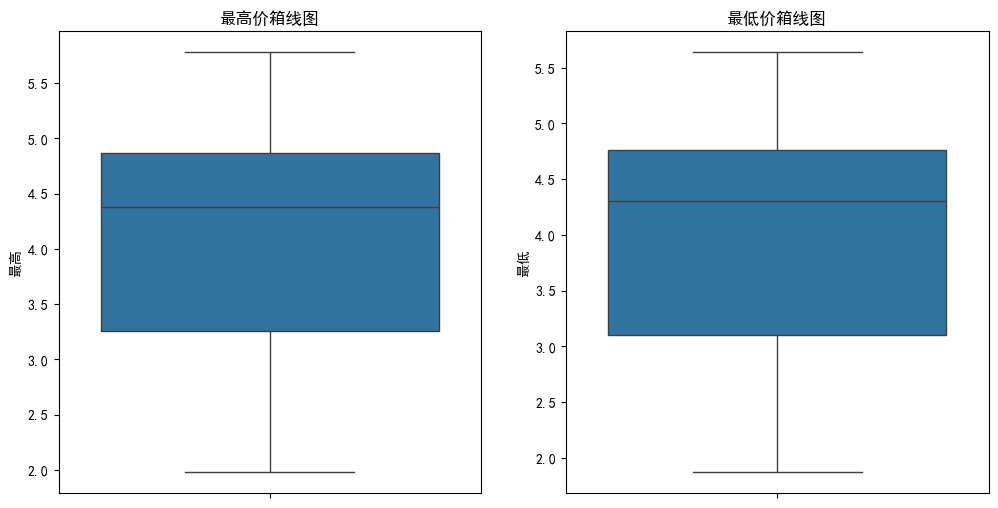

(501, 7)

In [20]:
# 绘制箱线图
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=data['最高'])
plt.title('最高价箱线图')

plt.subplot(1, 2, 2)
sns.boxplot(y=data['最低'])
plt.title('最低价箱线图')

plt.show()

# 删除异常值
Q1 = data[['最高', '最低']].quantile(0.25)
Q3 = data[['最高', '最低']].quantile(0.75)
IQR = Q3 - Q1

data = data[~((data[['最高', '最低']] < (Q1 - 1.5 * IQR)) | (data[['最高', '最低']] > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

数据没有异常值，说明比较接近理想数据，接下来进行特征构造

In [21]:
# 构造特征：成交量变化率
data['成交量变化率'] = data['成交量(手)'].pct_change()
data['成交量变化率'].head()

0         NaN
1   -0.182986
2   -0.201684
3    0.290036
4    0.284075
Name: 成交量变化率, dtype: float64

In [22]:
data['波动率'] = (data['最高'] - data['最低']) / data['最低']

In [23]:
data['成交量金额比'] = data['成交量(手)'] / data['成交金额(万)']

In [24]:
data.head()

,日期,涨跌额,最低,最高,成交量(手),成交金额(万),换手率,成交量变化率,波动率,成交量金额比
0,2024-09-30,0.28,3.03,3.32,1220325,39156.35,7.64,NaN,0.095710,31.165443
1,2024-09-27,0.11,2.92,3.10,997023,29919.40,6.24,-0.182986,0.061644,33.323629
2,2024-09-26,0.05,2.82,2.93,795939,23090.30,4.99,-0.201684,0.039007,34.470708
3,2024-09-25,-0.03,2.83,2.97,1026790,29782.44,6.43,0.290036,0.049470,34.476356
4,2024-09-24,0.02,2.79,2.97,1318475,37882.04,8.26,0.284075,0.064516,34.804752


由于特征构造设计前一个数据，因此表中第一行数据必然是缺失，将其删除

In [25]:
data = data.dropna()
data.shape

(500, 10)

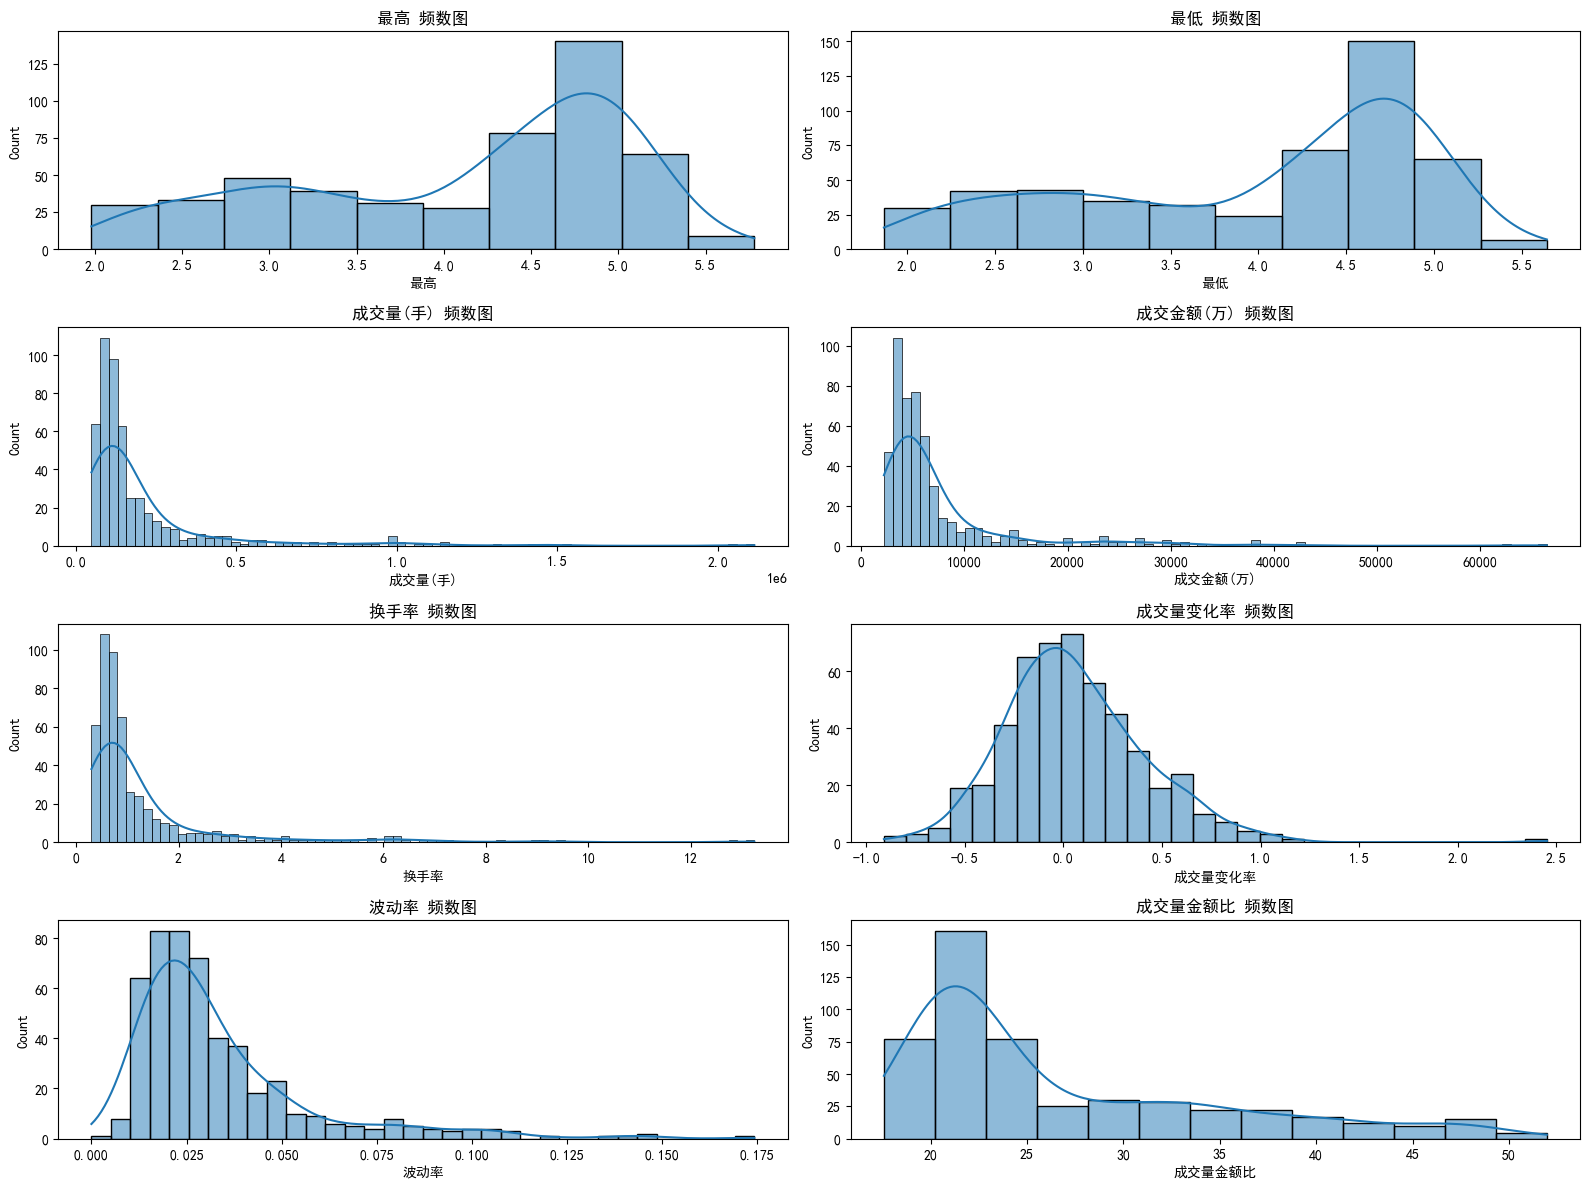

In [26]:
# 画出所有特征的频数图
features = ['最高', '最低', '成交量(手)', '成交金额(万)', '换手率', '成交量变化率', '波动率', '成交量金额比']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features):
    plt.subplot(4, 2, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'{feature} 频数图')

plt.tight_layout()
plt.show()

由于成交量，成交金额，换手率偏度较大，采用对数变换处理

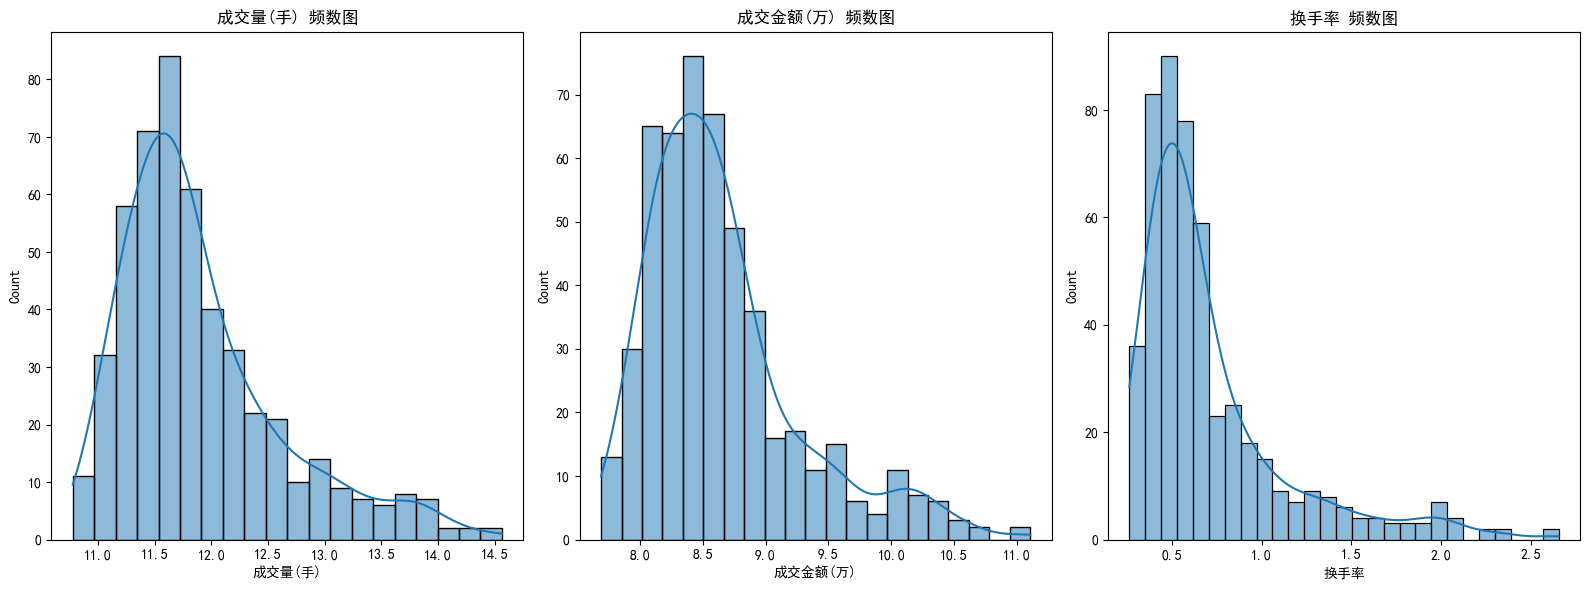

In [27]:
# log1p即为log(x+1)
data['成交量(手)'] = np.log1p(data['成交量(手)'])
data['成交金额(万)'] = np.log1p(data['成交金额(万)'])
data['换手率'] = np.log1p(data['换手率'])

plt.figure(figsize=(16, 6))

for i, feature in enumerate(['成交量(手)', '成交金额(万)', '换手率']):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data[feature], kde=True)
    plt.title(f'{feature} 频数图')

plt.tight_layout()
plt.show()

## 3.建模调参

In [28]:
# 将数据分为训练集和测试集，其中训练集是2024年9月之前的数据
train_data = data[data['日期'] < '2024-09-01']
test_data = data[data['日期'] >= '2024-09-01']

print("训练集大小:", train_data.shape)
print("测试集大小:", test_data.shape)

训练集大小: (482, 10)
测试集大小: (18, 10)


In [29]:
y_train_high = train_data['最高']
y_train_low = train_data['最低']
y_test_high = test_data['最高']
y_test_low = test_data['最低']

X_train = train_data.drop(columns=['日期', '最高', '最低'])
X_test = test_data.drop(columns=['日期', '最高', '最低'])

In [30]:
from sklearn.linear_model import LinearRegression

model_high = LinearRegression()
model_high.fit(X_train, y_train_high)

LinearRegression()

In [31]:
# 输出权重
coefficients = model_high.coef_
features = X_train.columns

for feature, coef in zip(features, coefficients):
    print(f'{feature}: {coef}')

涨跌额: -0.15125725956804245
成交量(手): -6.904843250160778
成交金额(万): 6.9518746628614805
换手率: -0.05755947823245866
成交量变化率: -0.005149597101684833
波动率: 1.6984212944464667
成交量金额比: 0.11206742240268408


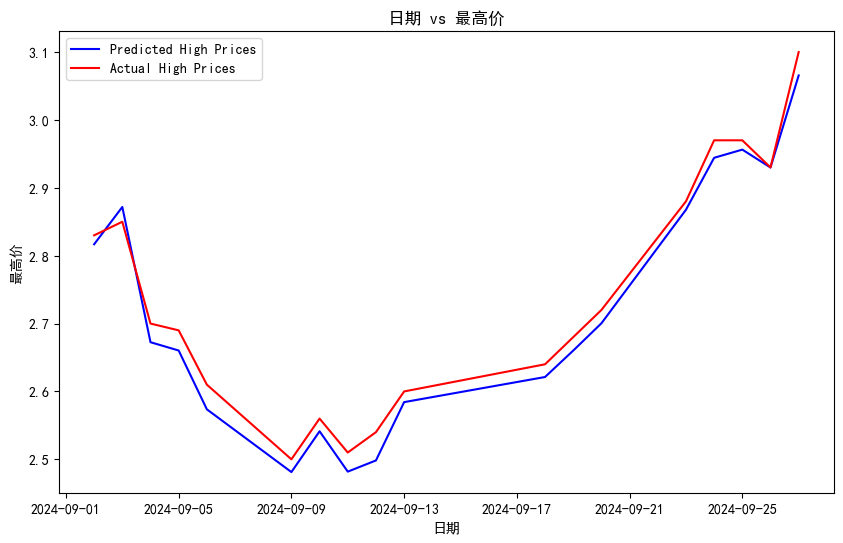

In [32]:
# 预测测试集的最高价
y_pred_high = model_high.predict(X_test)

# 绘制散点图
plt.figure(figsize=(10, 6))
plt.plot(test_data['日期'], y_pred_high, color='blue', label='Predicted High Prices')
plt.plot(test_data['日期'], y_test_high, color='red', label='Actual High Prices')
plt.xlabel('日期')
plt.ylabel('最高价')
plt.title('日期 vs 最高价')
plt.legend()
plt.show()

### xgboost

In [103]:
# 设置参数网格
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 正则化
    'reg_lambda': [1, 1.5, 2]  # L2 正则化
}

# 创建 XGBoost 模型
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# 使用 GridSearchCV 进行参数搜索
grid_search_high = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search_high.fit(X_train, y_train_high)

grid_search_low = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search_low.fit(X_train, y_train_low)

# 获取最佳参数和模型
best_params_high = grid_search_high.best_params_
best_model_high = grid_search_high.best_estimator_

best_params_low = grid_search_low.best_params_
best_model_low = grid_search_low.best_estimator_

print(f'Best parameters found: {best_params_high}')
print(f'Best parameters found: {best_params_low}')

# 使用最佳模型进行预测和评估
y_pred = best_model_high.predict(X_test)
mse = mean_squared_error(y_test_high, y_pred)
print(f'Mean Squared Error: {mse}')

y_pred = best_model_low.predict(X_test)
mse = mean_squared_error(y_test_low, y_pred)
print(f'Mean Squared Error: {mse}')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Mean Squared Error: 0.0019518103608453438
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Best parameters found: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 2, 'subsample': 0.8}
Mean Squared Error: 0.03130559814330248


Mean Squared Error: 0.0019518103608453438


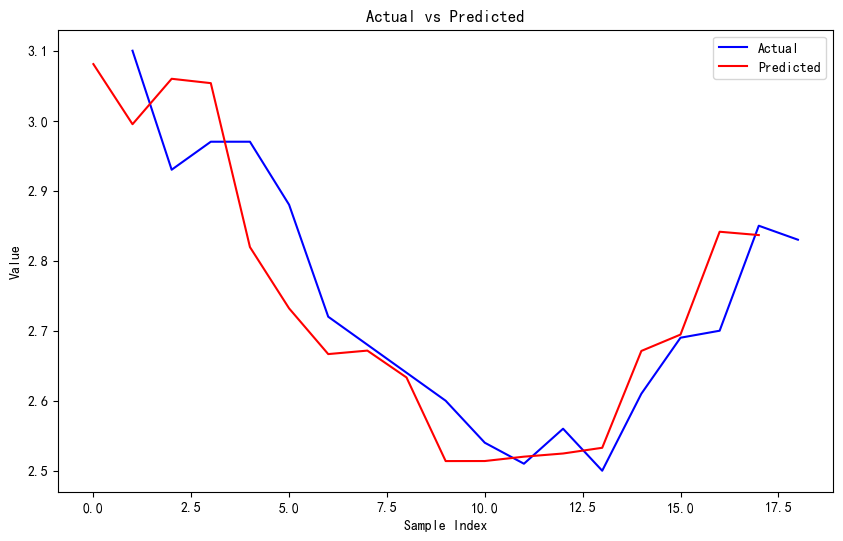

In [104]:
y_pred = best_model_low.predict(X_test)
mse = mean_squared_error(y_test_high, y_pred)
print(f'Mean Squared Error: {mse}')

# 绘制实际值和预测值的折线图
plt.figure(figsize=(10, 6))

# 绘制实际值
plt.plot(y_test_high, label='Actual', color='blue')

# 绘制预测值
plt.plot(y_pred, label='Predicted', color='red')

# 添加标题和标签
plt.title('Actual vs Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

预测其他股票，查看MSE

In [54]:
with open('data/filename', 'r') as file:
    file_names = file.read().splitlines()
file_names

['000016深康佳Ａ.csv',
 '000021深科技.csv',
 '000818航锦科技.csv',
 '001309德明利.csv',
 '002049紫光国微.csv',
 '002077大港股份.csv',
 '002119康强电子.csv',
 '002183怡亚通.csv',
 '002185华天科技.csv',
 '002213大为股份.csv',
 '002409雅克科技.csv',
 '002413雷科防务.csv',
 '002559亚威股份.csv',
 '002579中京电子.csv',
 '002654万润科技.csv',
 '300042朗科科技.csv',
 '300053航宇微.csv',
 '300131英唐智控.csv',
 '300184力源信息.csv',
 '300223北京君正.csv',
 '300236上海新阳.csv',
 '300302同有科技.csv',
 '300455航天智装.csv',
 '300475香农芯创.csv',
 '300551古鳌科技.csv',
 '300567精测电子.csv',
 '300672国科微.csv',
 '300857协创数据.csv',
 '300903科翔股份.csv',
 '301099雅创电子.csv',
 '301306西测测试.csv',
 '301308江波龙.csv',
 '600171上海贝岭.csv',
 '600584长电科技.csv',
 '600667太极实业.csv',
 '603986兆易创新.csv',
 '688008澜起科技.csv',
 '688110东芯股份.csv',
 '688123聚辰股份.csv',
 '688262国芯科技.csv',
 '688347华虹公司.csv',
 '688416恒烁股份.csv',
 '688478晶升股份.csv',
 '688525佰维存储.csv',
 '688589力合微.csv',
 '688611杭州柯林.csv',
 '688627精智达.csv',
 '688652京仪装备.csv',
 '688709成都华微.csv',
 '688766普冉股份.csv']

In [58]:
def deal_data(data):
    data['日期'] = pd.to_datetime(data['日期'])

    data['涨跌幅'] = data['涨跌幅'].str.rstrip('%').astype(float)
    data['换手率'] = data['换手率'].str.rstrip('%').astype(float)

    data = data.drop(columns=['收盘', '开盘', '涨跌幅'])

    # # 删除异常值
    # Q1 = data[['最高', '最低']].quantile(0.25)
    # Q3 = data[['最高', '最低']].quantile(0.75)
    # IQR = Q3 - Q1

    # data = data[~((data[['最高', '最低']] < (Q1 - 1.5 * IQR)) | (data[['最高', '最低']] > (Q3 + 1.5 * IQR))).any(axis=1)]

    data['成交量变化率'] = data['成交量(手)'].pct_change()

    data['波动率'] = (data['最高'] - data['最低']) / data['最低']

    data['成交量金额比'] = data['成交量(手)'] / data['成交金额(万)']

    data = data.dropna()

    data['成交量(手)'] = np.log1p(data['成交量(手)'])
    data['成交金额(万)'] = np.log1p(data['成交金额(万)'])
    data['换手率'] = np.log1p(data['换手率'])

    train_data = data[data['日期'] < '2024-09-01']
    test_data = data[data['日期'] >= '2024-09-01']

    return train_data, test_data



In [108]:
for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    # 使用训练好的模型进行预测
    y_pred_high = best_model_low.predict(X_test)

    mse = mean_squared_error(y_test_high, y_pred_high)
    print(f'{file} - Mean Squared Error: {mse}')


000016深康佳Ａ.csv - Mean Squared Error: 0.0019518103608453438
000021深科技.csv - Mean Squared Error: 62.291064682627876
000818航锦科技.csv - Mean Squared Error: 91.62716087126377
001309德明利.csv - Mean Squared Error: 3889.8871414490222
002049紫光国微.csv - Mean Squared Error: 1804.6857246750412
002077大港股份.csv - Mean Squared Error: 30.213176338833552
002119康强电子.csv - Mean Squared Error: 24.66402350584905
002183怡亚通.csv - Mean Squared Error: 0.0028989696628114107
002185华天科技.csv - Mean Squared Error: 4.054678051735862
002213大为股份.csv - Mean Squared Error: 16.179281971831827
002409雅克科技.csv - Mean Squared Error: 2150.1598477566617
002413雷科防务.csv - Mean Squared Error: 0.001662422448694028
002559亚威股份.csv - Mean Squared Error: 2.0380159569988283
002579中京电子.csv - Mean Squared Error: 1.5179375346135962
002654万润科技.csv - Mean Squared Error: 14.20118592523647
300042朗科科技.csv - Mean Squared Error: 123.42169460002586
300053航宇微.csv - Mean Squared Error: 15.092560131032473
300131英唐智控.csv - Mean Squared Error: 0.017197269

可以看出mse很大，接下来训练多个模型软投票

## 模型融合

xgboost 软投票

In [111]:
def getModel(X_train, y_train_high, y_train_low):
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

    grid_search_high = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search_high.fit(X_train, y_train_high)
    grid_search_low = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
    grid_search_low.fit(X_train, y_train_low)

    return grid_search_high.best_estimator_, grid_search_low.best_estimator_

In [113]:
a = []
b = []
for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    model_high, model_low = getModel(X_train, y_train_high, y_train_low)
    a.append(model_high)
    b.append(model_low)
    print(f'{file} fit over')

Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000016深康佳Ａ.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000021深科技.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
000818航锦科技.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
001309德明利.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
002049紫光国微.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
002077大港股份.csv fit over
Fitting 3 folds for each of 972 candidates, totalling 2916 fits
Fitting 3 folds for each o

In [114]:
softvote_high = VotingRegressor(estimators=a)
softvote_low = VotingRegressor(estimators=b)

In [115]:
joblib.dump(softvote_high, 'model/softvote_high.pkl')
joblib.dump(softvote_low, 'model/softvote_low.pkl')

['model/softvote_low.pkl']

In [34]:
softvote_low = joblib.load('model/softvote_low.pkl')
softvote_high = joblib.load('model/softvote_high.pkl')

In [46]:
tmp = []
j = 0
for i in softvote_high.estimators:
    tmp.append(('tmp' + str(j), i))
    j += 1
softvote_high = VotingRegressor(estimators=tmp)

In [47]:
tmp = []
j = 0
for i in softvote_low.estimators:
    tmp.append(('tmp' + str(j), i))
    j += 1
softvote_low = VotingRegressor(estimators=tmp)

In [62]:
for file in file_names:
    file_path = os.path.join('data', file)

    data = pd.read_csv(file_path)

    train_data, test_data = deal_data(data)

    y_train_high = train_data['最高']
    y_train_low = train_data['最低']
    y_test_high = test_data['最高']
    y_test_low = test_data['最低']

    X_train = train_data.drop(columns=['日期', '最高', '最低'])
    X_test = test_data.drop(columns=['日期', '最高', '最低'])

    # 使用训练好的模型进行预测
    softvote_high.fit(X_train, y_train_high)
    y_pred_high = softvote_high.predict(X_test)

    softvote_low.fit(X_train, y_train_low)
    y_pred_low = softvote_low.predict(X_test)

    mse_high = mean_squared_error(y_test_high, y_pred_high)
    mse_low = mean_squared_error(y_test_low, y_pred_low)
    print(f'{file}: {mse_high}, {mse_low}')

000016深康佳Ａ.csv: 0.0016151321339640402, 0.000858212985456207
000021深科技.csv: 0.0026191422745941214, 0.002926528780834547
000818航锦科技.csv: 0.951336025068976, 0.8656483627770596
001309德明利.csv: 0.20736393514016435, 0.10090400275215752
002049紫光国微.csv: 0.3175427441915109, 0.10945592648425792
002077大港股份.csv: 0.0018958094173129676, 0.001597212339946681
002119康强电子.csv: 0.0034241283267682217, 0.002094963624506207
002183怡亚通.csv: 0.0008620684972772676, 0.0012932928233144443
002185华天科技.csv: 0.0014531714089914332, 0.001128505766583364
002213大为股份.csv: 0.002591066957870244, 0.0033447033559627568
002409雅克科技.csv: 0.0656018237758117, 0.07926712540323015
002413雷科防务.csv: 0.0004678042339971519, 0.00012298186943778894
002559亚威股份.csv: 0.0015145449613919316, 0.0021435790512991573
002579中京电子.csv: 0.001593323649041784, 0.001336569982978412
002654万润科技.csv: 0.003150276985342669, 0.002552734521692566
300042朗科科技.csv: 0.14365613920801545, 0.023397346823726274
300053航宇微.csv: 0.0032836295716291543, 0.0037152318315100954
